**Проведен эксперимент на пользователях в течении двух недель.** <br>
Предоставлены сырые данные, которые необходимо обработать и сделать выводы

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binomtest
from scipy.stats import mannwhitneyu
import hashlib
from scipy.stats import ttest_ind

In [2]:
views = pd.read_csv('views.csv')
likes = pd.read_csv('likes.csv')

In [3]:
views.head()

,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825
3,37703,test,[2842 1949 162 1588 6794],1654030826
4,14661,test,[2395 5881 5648 3417 673],1654030829


In [4]:
likes.head()

,user_id,post_id,timestamp
0,128381,4704,1654030804
1,146885,1399,1654030816
2,50948,2315,1654030828
3,14661,673,1654030831
4,37703,1588,1654030833


Посмотрим на соотношение контрольной и тестовой групп

<Axes: xlabel='exp_group', ylabel='Count'>

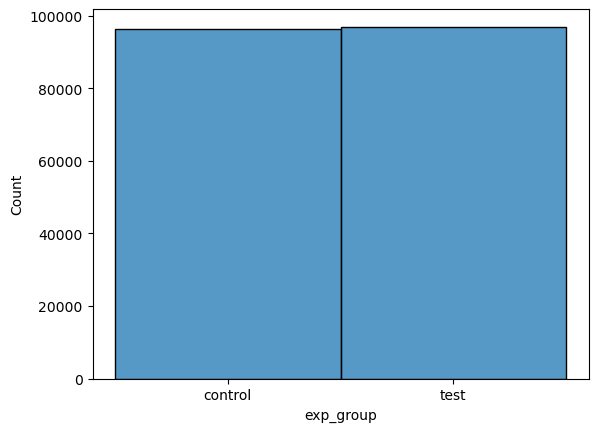

In [6]:
sns.histplot(data=views['exp_group'])

Так как группа пользователя определялась прямо перед рекомендациями, то таблички "пользователь-группа" нет. Нужно посмотреть, точно ли однозначное соответствие пользователя группе

In [9]:
users_to_group = views.groupby('user_id').exp_group.nunique().reset_index()
users_to_group.head()

,user_id,exp_group
0,200,1
1,201,1
2,202,1
3,212,1
4,213,1


In [10]:
users_to_group[users_to_group['exp_group']>1]

,user_id,exp_group
10071,25623,2
20633,55788,2
54475,142283,2
57065,148670,2


Нашлись пользователи, которые попали в обеи группы. Удалим их

In [11]:
users_to_remove = users_to_group[users_to_group.exp_group > 1].user_id.values

views = views[~np.in1d(views.user_id, users_to_remove)]
likes = likes[~np.in1d(likes.user_id, users_to_remove)]

Проверим, одинаковый ли размер групп 

In [15]:
views.groupby('user_id').first().exp_group.value_counts()

test       32659
control    32350
Name: exp_group, dtype: int64

In [18]:
views['user_id'].nunique()

65009

Проведем бином тест, чтобы убедиться, что группы разбиты нормально

In [20]:
binomtest(32350, 65009, p=0.5)

BinomTestResult(k=32350, n=65009, alternative='two-sided', statistic=0.49762340598993987, pvalue=0.2270501563614752)

pvalue=0.227, значит мы принимаем нулевую гипотезу о том, что группы равного размера

Посмотрим, какая часть пользователей поставила хотя бы одну реакцию за время эксперимента

In [23]:
groups = views.groupby('user_id').first().reset_index()[['user_id', 'exp_group']]
groups.head()

,user_id,exp_group
0,200,test
1,201,test
2,202,test
3,212,test
4,213,test


In [25]:
likes_per_user = (
    likes
    .groupby('user_id')
    .post_id.count()
    .reset_index()
    .rename(columns={'post_id': 'like_num'})
)

likes_per_user.head()

,user_id,like_num
0,200,1
1,201,3
2,202,2
3,212,4
4,213,7


In [26]:
percentage_of_likers = 1 - (len(views.user_id.unique()) - len(likes_per_user)) / len(views.user_id.unique())
print(f"Хотя бы 1 лайк в ходе эксперимента поставило: {round(percentage_of_likers, 4)*100}% пользователей")

Хотя бы 1 лайк в ходе эксперимента поставило: 89.48% пользователей


In [27]:
user_likes = pd.merge(groups, likes_per_user, on='user_id', how='left')
user_likes.like_num = user_likes.like_num.fillna(0)
user_likes['has_like'] = (user_likes['like_num'] > 0).astype(int)
user_likes.head()

,user_id,exp_group,like_num,has_like
0,200,test,1.0,1
1,201,test,3.0,1
2,202,test,2.0,1
3,212,test,4.0,1
4,213,test,7.0,1


In [28]:
likes_per_user_grouped = user_likes.groupby('exp_group')[['has_like', 'like_num']].mean()
likes_per_user_grouped.rename(columns={'like_num': 'avg_like_num'})

,has_like,avg_like_num
exp_group,,
control,0.891314,3.487079
test,0.898160,3.592578


Проверим доли пользователей с хотя бы одним лайком и число лайков на пользователя

<Axes: xlabel='like_num', ylabel='Count'>

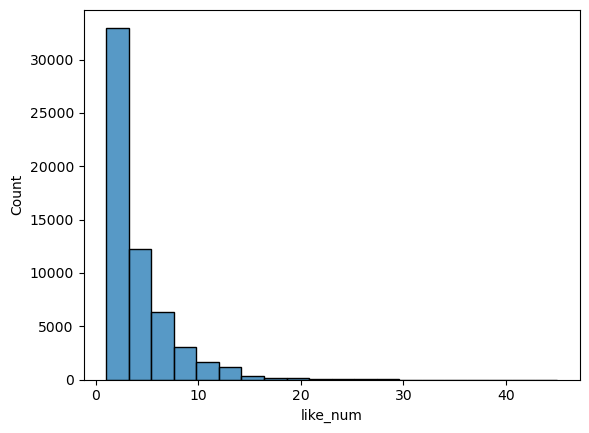

In [29]:
sns.histplot(likes_per_user.like_num, bins=20)

У нас логнормальное распределение. Воспользумся критерием Манна-Уитни-Уилкоксона

In [31]:
mannwhitneyu(
    user_likes[user_likes.exp_group == 'control'].like_num,
    user_likes[user_likes.exp_group == 'test'].like_num,
)

MannwhitneyuResult(statistic=518358073.0, pvalue=2.9585062792441964e-05)

pvalue=2.96E-5 а значит, что изменения значимые

Посчитаем hitrate. У нас нет айди по которому можно сджойнить, поэтому сделаим джойн по пользователям всех лайков и всех показов рекомендаций. Отфильтруем по времени показ от лайка (возьмём за отсечку 1 час)

In [32]:
pivot = pd.merge(views, likes, on='user_id', how='outer')
pivot.post_id = pivot.post_id.fillna(-1).astype(int)
pivot.head()

,user_id,exp_group,recommendations,timestamp_x,post_id,timestamp_y
0,128381,control,[3644 4529 4704 5294 4808],1654030803,4704,1.654031e+09
1,128381,control,[3644 4529 4704 5294 4808],1654030803,5294,1.654031e+09
2,128381,control,[3644 4529 4704 5294 4808],1654030803,3608,1.655049e+09
3,128381,control,[3644 4529 4704 5294 4808],1654030803,2542,1.655049e+09
4,128381,control,[3644 4529 4704 5294 4808],1654030803,4165,1.655053e+09


In [33]:
pivot['recommendations'] = pivot.recommendations.apply(
    lambda x: list(map(int, filter(bool, x[1:-1].split(' '))))
)
pivot.head()

,user_id,exp_group,recommendations,timestamp_x,post_id,timestamp_y
0,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,4704,1.654031e+09
1,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,5294,1.654031e+09
2,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,3608,1.655049e+09
3,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,2542,1.655049e+09
4,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,4165,1.655053e+09


In [34]:
pivot.post_id = pivot.apply(
    lambda row:
    -1
    if
        (row.post_id == -1) | 
        ((row.timestamp_x > row.timestamp_y) |
         (row.timestamp_x + 60 * 60 < row.timestamp_y)) |
        (row.post_id not in row.recommendations)
    else
    row.post_id, axis=1)

In [35]:
def my_agg(values):
    values = set(values)
    if -1 in values and len(values) >= 2:
        return 1
    elif -1 not in values:
        return 1
    return 0

agg = pivot.groupby(['user_id', 'exp_group', 'timestamp_x']).post_id.agg(my_agg)
agg.reset_index().post_id.mean()

0.7132582734855227

Доля показов рекомендованных постом с хотя бы одним лайком: 71.33%

Оценим различие между группами и значимость. Применим бакетный подход, уровень значимости 0.05.

In [36]:
agg = agg.reset_index().rename(columns={'post_id': 'hitrate'})

In [39]:
agg['bucket'] = agg['user_id'].apply(
    lambda x: int(hashlib.md5((str(x) + 'bbb').encode()).hexdigest(), 16) % 100
)

In [40]:
agg.head()

,user_id,exp_group,timestamp_x,hitrate,bucket
0,200,test,1655009047,1,97
1,201,test,1654043283,0,39
2,201,test,1654173790,0,39
3,201,test,1654444704,1,39
4,201,test,1654517459,0,39


In [41]:
agg['view'] = 1

new_df = agg.groupby(['exp_group', 'bucket']).sum(['hitrate', 'view']).reset_index()
new_df['hitrate_new'] = new_df.hitrate / new_df.view

new_df.head()

,exp_group,bucket,user_id,timestamp_x,hitrate,view,hitrate_new
0,control,0,75055655,1472627637383,621,890,0.697753
1,control,1,78264361,1557009869357,666,941,0.707758
2,control,2,89756485,1664574067853,705,1006,0.700795
3,control,3,74901253,1523924072519,645,921,0.700326
4,control,4,77518818,1603347973264,710,969,0.732714


In [42]:
agg.groupby('exp_group').hitrate.mean()

exp_group
control    0.706651
test       0.719829
Name: hitrate, dtype: float64

Разница почти в 2%. Оценим значимость

In [44]:
mannwhitneyu(
    new_df[new_df.exp_group == 'control'].hitrate_new,
    new_df[new_df.exp_group == 'test'].hitrate_new,
)

MannwhitneyuResult(statistic=2474.0, pvalue=6.795052834951048e-10)

In [45]:
ttest_ind(
    new_df[new_df.exp_group == 'control'].hitrate_new,
    new_df[new_df.exp_group == 'test'].hitrate_new,
)

Ttest_indResult(statistic=-6.283293948472979, pvalue=2.0664050599155474e-09)

pvalue в обоих тестах показывает, что мы можем отклонить нулевую гипотезу о том, что модели рекомендует одинаково. Изменение значимое